# Sequence Generation

TODO using pre-trained models...

## Imports

In [1]:
import sys
import logging
import json
import music21
import os
from music21 import converter

# Add Midi2Vec to Python working directory
sys.path.append('../')

from encoding import Encoder
from sequence_learning import SequenceLearner, SequenceGenerator
from data_loading import MidiDataLoader
from midi_to_dataframe import NoteMapper, MidiWriter

/usr/local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## Logging Configuration

In [2]:
logger = logging.getLogger()
logger.level = logging.INFO
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

## Load Pre-Trained Models

In [3]:
model_path = "models/bach_chorales-0.6"
settings_path = model_path + "/settings.json"
encoder_path = model_path + "/encoder"
seq_path = model_path + "/seq.h5"

# Load model parameters
with open(settings_path) as f:
    model_params = json.load(f)
    
# Load Encoder (Doc2Vec)
encoder = Encoder(model_params)
encoder.load(encoder_path)

# Load SequenceLearner (Keras)
sequence_model = SequenceLearner(model_params)
sequence_model.load(seq_path)

loading Doc2Vec object from models/bach_chorales-0.6/encoder
loading vocabulary recursively from models/bach_chorales-0.6/encoder.vocabulary.* with mmap=None
loading docvecs recursively from models/bach_chorales-0.6/encoder.docvecs.* with mmap=None
loading vectors_docs from models/bach_chorales-0.6/encoder.docvecs.vectors_docs.npy with mmap=None
loading trainables recursively from models/bach_chorales-0.6/encoder.trainables.* with mmap=None
loading wv recursively from models/bach_chorales-0.6/encoder.wv.* with mmap=None
loaded models/bach_chorales-0.6/encoder
Encoder loaded from: models/bach_chorales-0.6/encoder
SequenceLearner loaded from: models/bach_chorales-0.6/seq.h5


## Define Seed Sequences

In [4]:
# Bach
seed_sequences = ["../resources/midi/bach_chorales/01-AchGottundHerr.mid",
                 "../resources/midi/bach_chorales/02-AchLiebenChristen.mid",
                 "../resources/midi/bach_chorales/03-ChristederdubistTagundLicht.mid",
                 "../resources/midi/bach_chorales/04-ChristeDuBeistand.mid",
                 "../resources/midi/bach_chorales/05-DieNacht.mid",
                 "../resources/midi/bach_chorales/06-DieSonne.mid",
                 "../resources/midi/bach_chorales/07-HerrGott.mid",
                 "../resources/midi/bach_chorales/08-FuerDeinenThron.mid",
                 "../resources/midi/bach_chorales/09-Jesus.mid",
                 "../resources/midi/bach_chorales/10-NunBitten.mid"]

In [5]:
# Define note mapper for MIDI file loading
note_mapping_config_path = "../settings/map-to-group.json"
note_mapper = NoteMapper(note_mapping_config_path)

# Load training MIDI files using MidiDataLoader
# TODO I think this is necessary to fill the encoder vector cache (?)
data_loader = MidiDataLoader(note_mapper, params=model_params, encoder=encoder)
data = data_loader.load_data(seed_sequences)

test_seq_0.mid


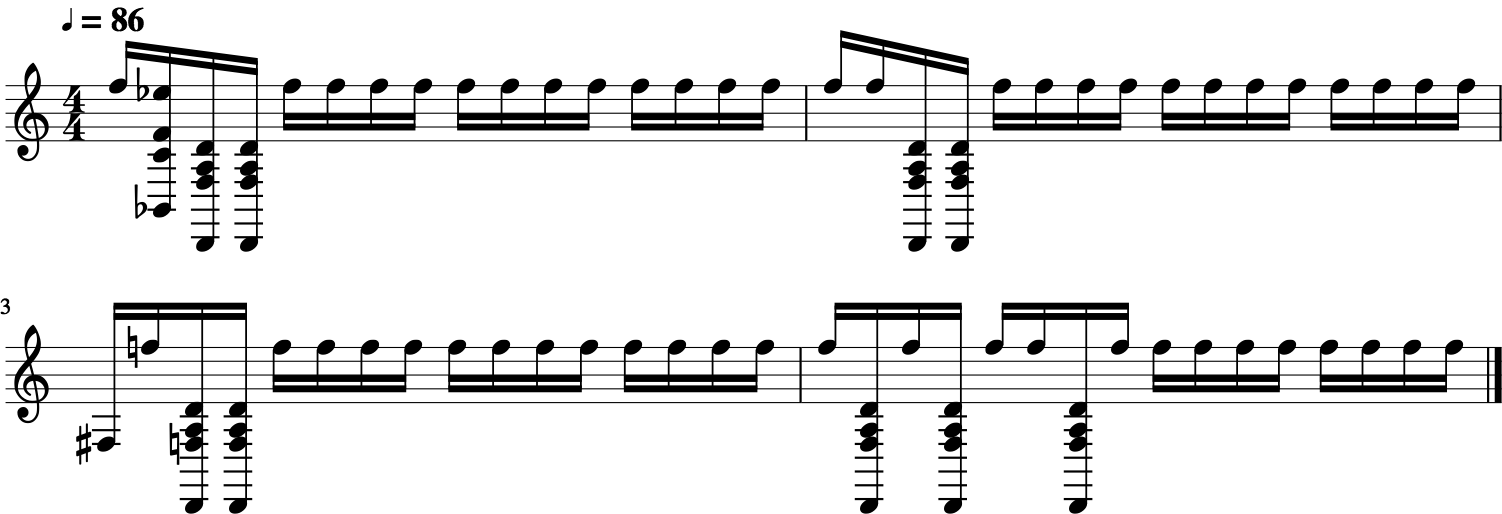

In [6]:
sequence_generator = SequenceGenerator(data_loader, sequence_model)
length = 64

for seq_index, seed in enumerate(seed_sequences):
    generated_seq_df = sequence_generator.generate(seed, length)

    writer = MidiWriter(note_mapper)
    # TODO, output to path of saved model
    # TODO start incrementing at last index
    save_to_path = "test_seq_" + str(seq_index) + ".mid"
    writer.convert_to_midi(generated_seq_df, save_to_path)
    print(save_to_path)
    mid = converter.parse(save_to_path)
    mid.measures(0, 4).show()
    #print("---")
    break

    

In [13]:
from midi_to_dataframe import MidiReader

reader = MidiReader(note_mapper)
reader.convert_to_dataframe(seed)

,timestamp,bpm,time_signature,measure,beat,notes
0,0,93.999834,4/4,1,1.00,rest
1,256,93.999834,4/4,1,1.25,rest
2,512,93.999834,4/4,1,1.50,rest
3,768,93.999834,4/4,1,1.75,rest
4,1024,93.999834,4/4,1,2.00,rest
5,1280,93.999834,4/4,1,2.25,rest
6,1536,93.999834,4/4,1,2.50,rest
7,1792,93.999834,4/4,1,2.75,rest
8,2048,93.999834,4/4,1,3.00,rest
9,2304,93.999834,4/4,1,3.25,rest
